In [9]:
from typing import Tuple
import numpy as np
import deepgp
import matplotlib.pyplot as plt
from datetime import datetime
import os

import GPy
from GPy.models import GPRegression
from emukit.test_functions import forrester_function
from emukit.core.initial_designs import RandomDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement, EntropySearch
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from gpflow.kernels import RBF, White, Linear
from tqdm import tqdm

from simulator import MainSimulator, TinySimulator
from world import DebugInfo
from pprint import pprint

main_simulator = MainSimulator()

In [10]:
def plot_prediction(X,Y,x_plot,mu_plot,var_plot,axis):
    axis.plot(X, Y, "ro", markersize=10, label="Observations")
    axis.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    axis.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
    axis.legend(loc=2, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [11]:
def plot_acquisition_functions(x_plot, ac_plots, x_new, axis):
    axis.plot(x_plot, (ac_plots[0][1] - np.min(ac_plots[0][1])) / (np.max(ac_plots[0][1]) - np.min(ac_plots[0][1])), label=ac_plots[0][0])
    axis.plot(x_plot, (ac_plots[1][1] - np.min(ac_plots[1][1])) / (np.max(ac_plots[1][1]) - np.min(ac_plots[1][1])), label=ac_plots[1][0])
    axis.plot(x_plot, (ac_plots[2][1] - np.min(ac_plots[2][1])) / (np.max(ac_plots[2][1]) - np.min(ac_plots[2][1])), label=ac_plots[2][0])
    axis.plot(x_plot, (ac_plots[3][1] - np.min(ac_plots[3][1])) / (np.max(ac_plots[3][1]) - np.min(ac_plots[3][1])), label=ac_plots[3][0])

    axis.axvline(x_new, color="red", label="x_next", linestyle="--")
    axis.legend(loc=1, prop={'size': 10})
    axis.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    axis.grid(True)

In [29]:
import statistics

def target_function_list(X, repetition=10):
    Y = []
    for x in X:
        mutation_rates = {
            "size": x[0],
            "speed": x[1],
            "vision": x[2],
            "aggression": x[3]
        }
        # items = []
        total = 0
        for i in range(repetition):
            days_survived, log = main_simulator.run(mutation_rates, debug_info=DebugInfo(
                period=10, should_display_day=False, should_display_grid=False, should_display_traits=False), max_days=10000)
            #items.append(days_survived)
            total += days_survived
        #Y.append(statistics.median(items))
        Y.append(total//repetition)
    return np.array(Y)[:,np.newaxis]

In [30]:
# Generate the initial points to start the training process
def experiment_initialisation(num_data_points = 5):
    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                            ContinuousParameter('speed', 0, 1),
                            ContinuousParameter('vision', 0, 1),
                            ContinuousParameter('aggression', 0, 1)])
    design = RandomDesign(space) # Collect random points
    X = design.get_samples(num_data_points)
    Y = target_function_list(X)
    return X, Y

In [41]:
def model_generation(X, Y, kernel = None):
    if kernel is None:
        kernel_rbf_1 = GPy.kern.RBF(input_dim=1, lengthscale=0.05, variance=10, active_dims=[0])
        kernel_rbf_2 = GPy.kern.RBF(input_dim=1, lengthscale=0.05, variance=10, active_dims=[1])
        kernel_rbf_3 = GPy.kern.RBF(input_dim=1, lengthscale=0.05, variance=10, active_dims=[2])
        kernel_rbf_4 = GPy.kern.RBF(input_dim=1, lengthscale=0.05, variance=10, active_dims=[3])
        kernel = kernel_rbf_1 + kernel_rbf_2 + kernel_rbf_3 + kernel_rbf_4
    model_gpy = GPRegression(X,Y,kernel, noise_var=1) # Train and wrap the model in Emukit
    model_emukit = GPyModelWrapper(model_gpy)
    return model_emukit

In [48]:
iterations = 1000
# The other mutation rates for the projection
projection = 0
# Along which trait is the function plotted: 0-size, 1-speed, 2-vision, 3-aggression
plot = 0

# returns the mean square error history of the iterations
def train(modol_emukit, X, Y, iterations = 1000, plot = 0, projection = 0):

    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                            ContinuousParameter('speed', 0, 1),
                            ContinuousParameter('vision', 0, 1),
                            ContinuousParameter('aggression', 0, 1)])

    ei_acquisition = ExpectedImprovement(model = model_emukit)
    nlcb_acquisition = NegativeLowerConfidenceBound(model = model_emukit)
    pi_acquisition = ProbabilityOfImprovement(model = model_emukit)
    es_acquisition = EntropySearch(model = model_emukit, space = space)

    file_path = 'training_logs/plot_' + str(plot) + '_projection_' + str(projection) + '_' + str(datetime.now())
    os.makedirs(file_path)
    figure, axis = plt.subplots(1, 2, figsize=(20, 6))
    x_plot = np.linspace(0, 1, 1000)[:, None]
    x_paddings = np.linspace(projection, projection, 1000)[:, None]
    x_linear = np.linspace(0, 1, 1000)[:, None]

    history = []
    with open('dataset_test/mutation_rates.npy', 'rb') as f:
      X_test = np.load(f)
    with open('dataset_test/simulated_years_of_survival.npy', 'rb') as f:
      y_test = np.load(f)
    
    for i in tqdm(range(iterations)):
        for j in range(plot):
            x_plot = np.append(x_paddings, x_plot, axis = 1)
        for j in range(3-plot):
            x_plot = np.append(x_plot, x_paddings, axis = 1)
            
        mu_plot, var_plot = model_emukit.predict(x_plot)
        plot_prediction(X[:,plot],Y,x_linear,mu_plot,var_plot,axis[0])

        predictions, _ = model_emukit.predict(X_test)
        history.append(np.square(y_test - predictions).mean())
        
        ei_plot = ("EI",ei_acquisition.evaluate(x_plot))
        nlcb_plot = ("NLCB",nlcb_acquisition.evaluate(x_plot))
        pi_plot = ("PI",pi_acquisition.evaluate(x_plot))
        es_plot = ("ES",es_acquisition.evaluate(x_plot))
        
        optimizer = GradientAcquisitionOptimizer(space)
        x_new, _ = optimizer.optimize(es_acquisition)
        plot_acquisition_functions(x_linear, [ei_plot,nlcb_plot,pi_plot,es_plot], x_new[0][plot], axis[1])
        print("Next position to query:", x_new)
        
        y_new = target_function_list(x_new)
        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)
        model_emukit.set_data(X, Y)
        plt.savefig(file_path + '/' + str(i) +'.png')
        plt.clf()
        figure, axis = plt.subplots(1, 2, figsize=(20, 6))

        with open(file_path + '/history.npy', 'wb') as f:
            np.save(f, np.array(history))
    return history

In [60]:
def sensitivity_2d(X, sensitivity, x_a=0, y_a=1, projection = 0):
    results = []
    for x in X:
        point = np.array([projection, projection, projection, projection])
        point[x_a] = x[0]
        point[y_a] = x[1]
        results.append(sensitivity.compute_statistics(point)[0])
    return np.array(results)

In [ ]:
sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)

In [69]:
def plot_sensitivity_2d(model_emukit, x_a=0, y_a=1, projection = 0):
    space = ParameterSpace([ContinuousParameter('size', 0, 1),
                        ContinuousParameter('speed', 0, 1),
                        ContinuousParameter('vision', 0, 1),
                        ContinuousParameter('aggression', 0, 1)])
    
    sensitivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
    main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points = 10000)
    
    x_axis = np.linspace(0, 1, 100)
    y_axis = np.linspace(0, 1, 100)
    
    X_axis,Y_axis = np.meshgrid(x_axis, y_axis)
    data = np.vstack([X_axis.ravel(), Y_axis.ravel()])
    data = np.swapaxes(data,0,-1)
    
    plt.figure(figsize=(8,6))
    plt.contourf(X_axis, Y_axis, sensitivity_2d(data, sensitivity, x_a, y_a, projection).reshape(X_axis.shape), levels=20)
    plt.colorbar()
    return main_effects, total_effects

({'size': array([0.25863422]),
  'speed': array([0.18488859]),
  'vision': array([0.20678061]),
  'aggression': array([0.3671574])},
 {'size': array([0.32035887]),
  'speed': array([0.17890642]),
  'vision': array([0.1909202]),
  'aggression': array([0.31505788])})

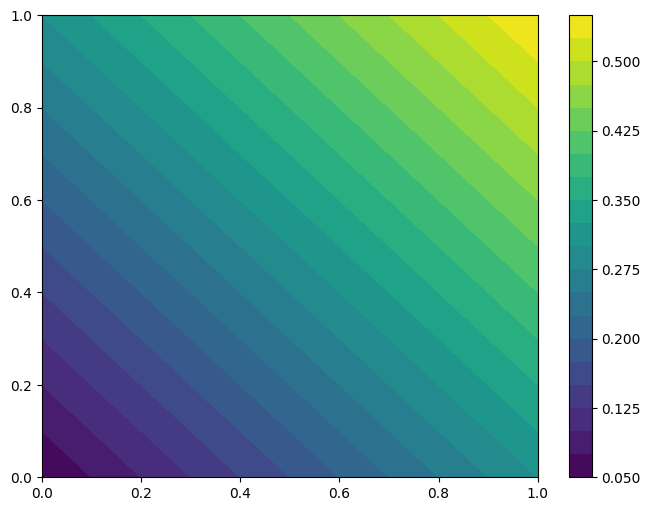

In [73]:
plot_sensitivity_2d(model, x_a=0, y_a=1, projection = 0.1)

In [ ]:
X, Y = experiment_initialisation()
model = model_generation(X, Y)
train(model, X, Y)

In [74]:
file_path = 'training_logs/plot_0_projection_0_2024-01-13 18:55:03.020726'
with open(file_path + '/history.npy', 'rb') as f:
    history = np.load(f)

In [76]:
x = np.array([i for i in range(len(history))])

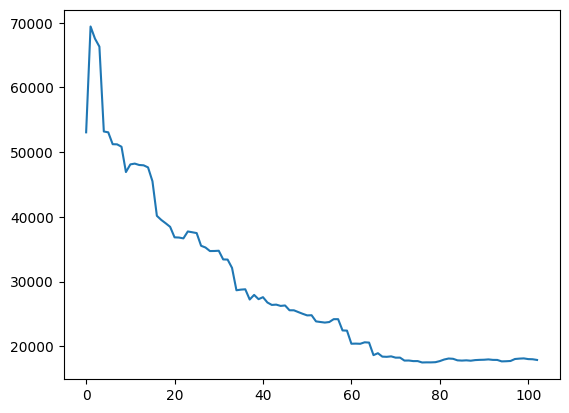

In [77]:
plt.plot(history)